In [2]:
import pystac_client
import planetary_computer as pc
from pyproj import Transformer
import xarray as xr
import stackstac
import numpy as np
import matplotlib
import zarr
import matplotlib.pyplot as plt

In [5]:
import xarray as xr
import zarr
print("xarray version:", xr.__version__)
print("zarr version:", zarr.__version__)

xarray version: 2024.11.0
zarr version: 2.18.3


In [18]:
ds = xr.open_zarr("/Net/Groups/BGI/work_2/scratch/DeepExtremes/dx-minicubes/full/1.3/mc_57.02_56.58_1.3_20231019_0.zarr")


In [62]:
transformer = Transformer.from_crs(4326, ds.attrs["spatial_ref"], always_xy=True)
bbox = transformer.transform_bounds(ds.x[0], ds.y[0], ds.x[-1], ds.y[-1], direction = 'INVERSE')
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=pc.sign_inplace,
)

search = catalog.search(
    collections=["esa-worldcover"],
    bbox=bbox,
)
items_esawc = search.get_all_items()
stack = stackstac.stack(items_esawc, assets = ["map"], bounds_latlon=bbox)

/Net/Groups/BGI/scratch/crobin/miniconda3/envs/LandcoverEnv/lib/python3.12/site-packages/pystac_client/item_search.py:903: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(


In [61]:
from pyproj import Transformer

# Transformer to convert from EPSG:32639 (projected) to EPSG:4326 (lat/lon)
transformer = Transformer.from_crs(32639, 4326, always_xy=True)

# Convert bbox to geographic coordinates
bbox_latlon = transformer.transform_bounds(ds.x[0], ds.y[0], ds.x[-1], ds.y[-1])

# Check the transformed bounding box
print("Transformed BBOX (lat/lon):", bbox_latlon)

# Use the transformed bbox for the STAC API query
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=pc.sign_inplace,
)

search = catalog.search(
    collections=["esa-worldcover"],
    bbox=bbox_latlon,  # Pass the bbox in lat/lon
)
items_esawc = search.get_all_items()

# Stack and reproject the data
stack = stackstac.stack(items_esawc, assets=["map"], bounds_latlon=bbox_latlon, xy_coords="center")

stack_reprojected = stackstac.reproject_array(
    stack,
    stackstac.raster_spec.RasterSpec(
        epsg=ds.attrs["spatial_ref"],
        bounds=ds.attrs["spatial_bbox"],
        resolutions_xy=(ds.attrs["spatial_res"], ds.attrs["spatial_res"]),
    ),
    interpolation="nearest",
)

# Check the alignment
print("Coordinate difference:", stack_reprojected.x.values - ds.x.values)

Transformed BBOX (lat/lon): (57.00124571154471, 56.5695970012156, 57.04598868812896, 56.594289288984186)
Coordinate difference: [-10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10.
 -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10.
 -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10.
 -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10.
 -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10.
 -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10.
 -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10.
 -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10.
 -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10.
 -10. -10.]


In [57]:
stack

<xarray.Dataset> Size: 3GB
Dimensions:      (latitude: 36000, longitude: 36000, time: 2)
Coordinates:
  * latitude     (latitude) float64 288kB 57.0 57.0 57.0 57.0 ... 54.0 54.0 54.0
  * longitude    (longitude) float64 288kB 57.0 57.0 57.0 ... 60.0 60.0 60.0
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 16B 2020-01-01 2021-01-01
Data variables:
    map          (time, latitude, longitude) uint8 3GB 40 40 40 40 ... 30 30 30

Text(0.5, 1.0, 'RGB Components on Earth Map')

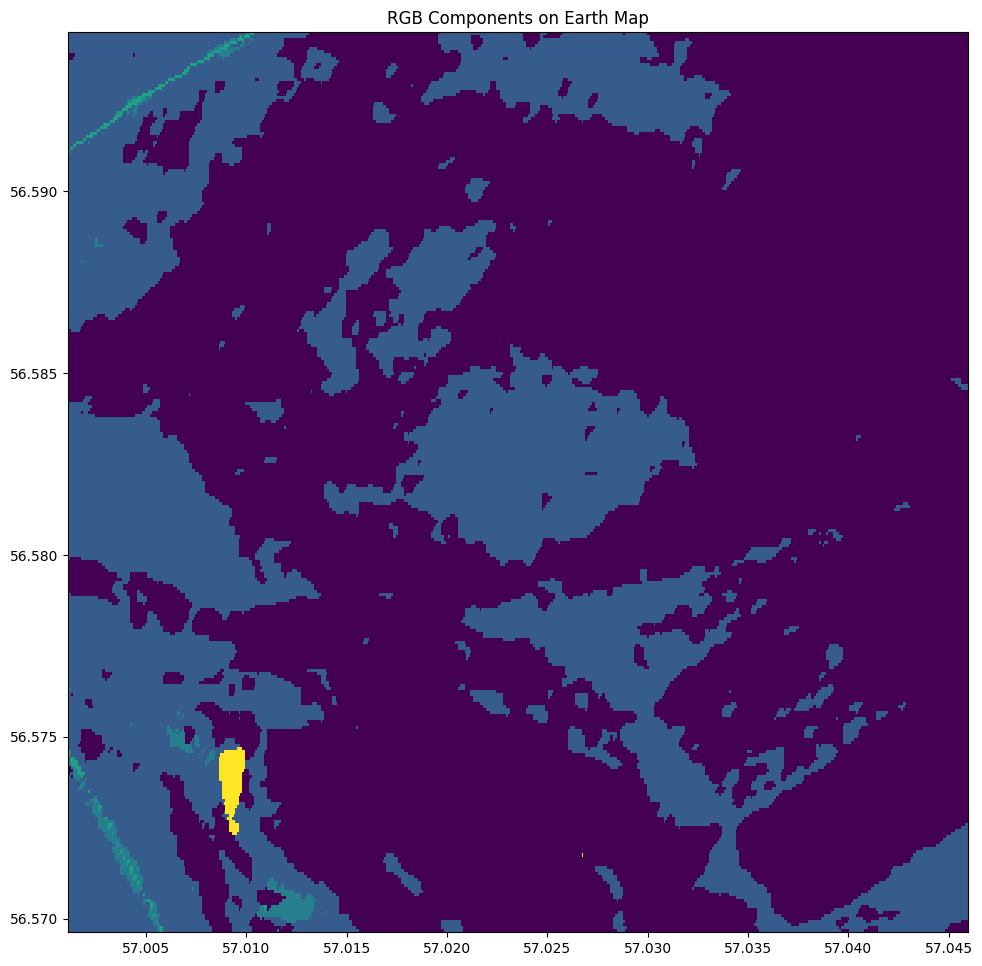

In [63]:
subset = stack.isel(band = 0, time=0).compute()
subset = subset.fillna(0)  # Replace NaT or NaN with 0 (or another placeholder)
#subset.plot.imshow()
# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 10))
# adjust the plot
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
ax.pcolormesh(
    subset.x.values,
    subset.y.values,
    subset.values,
    # transform=projection,
)
# Add a title
plt.title("RGB Components on Earth Map")


In [64]:
stack_reprojected = stackstac.reproject_array(stack, stackstac.raster_spec.RasterSpec(epsg= ds.attrs["spatial_ref"], bounds = ds.attrs["spatial_bbox"], resolutions_xy=(ds.attrs["spatial_res"], ds.attrs["spatial_res"])), interpolation="nearest")

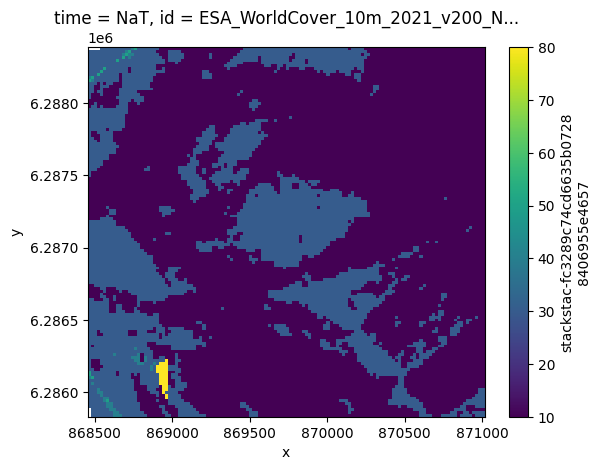

In [65]:
stack_reprojected.isel(time = 0, band = 0).plot()

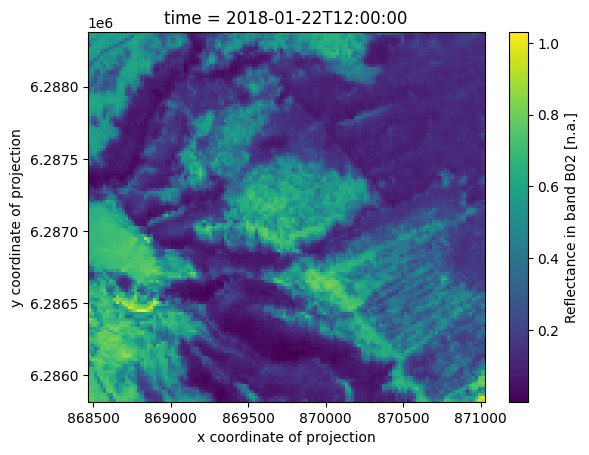

In [44]:
ds["B02"].isel(time = 150).plot()

In [66]:
(stack_reprojected.x.values - ds.x.values)

array([-10., -10., -10., -10., -10., -10., -10., -10., -10., -10., -10.,
       -10., -10., -10., -10., -10., -10., -10., -10., -10., -10., -10.,
       -10., -10., -10., -10., -10., -10., -10., -10., -10., -10., -10.,
       -10., -10., -10., -10., -10., -10., -10., -10., -10., -10., -10.,
       -10., -10., -10., -10., -10., -10., -10., -10., -10., -10., -10.,
       -10., -10., -10., -10., -10., -10., -10., -10., -10., -10., -10.,
       -10., -10., -10., -10., -10., -10., -10., -10., -10., -10., -10.,
       -10., -10., -10., -10., -10., -10., -10., -10., -10., -10., -10.,
       -10., -10., -10., -10., -10., -10., -10., -10., -10., -10., -10.,
       -10., -10., -10., -10., -10., -10., -10., -10., -10., -10., -10.,
       -10., -10., -10., -10., -10., -10., -10., -10., -10., -10., -10.,
       -10., -10., -10., -10., -10., -10., -10.])

In [41]:
print(stack_reprojected.x.values[0],  ds.x.values[0])

868466.0293839886 868476.0293839886


In [ ]:
# select the time step with valid values since Sentinel-2 5-daily. Sometimes data can also be missing. 
# Read more about Sentinel-2 
mask = minicube.cloudmask_en.where(ds.cloudmask_en == 0, np.nan)
mask = mask.where(ds.SCL != (4 or 5), 1)

# mask = ds.cloudmask_en.where(ds.cloudmask_en == 0, np.nan)
# # mask = mask.where(ds.SCL.isin([4, 5]), np.nan)
# mask = mask.where(mask != 0, 1)

fig, axes = plt.subplots(nrows=5, ncols=5, constrained_layout=True, figsize=(20, 20))
t= 0
for i in range(5):
    for j in range(5):
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        axes[i,j].set_title(ds.isel(time=t).time.dt.date.values)

        red = brighten(normalize(ds.isel(time=t).B04))
        green = brighten(normalize(ds.isel(time=t).B03))
        blue = brighten(normalize(ds.isel(time=t).B02))

        # Remove the cloud masking
        # red = red * mask.isel(time=t)
        # green = green * mask.isel(time=t) 
        # blue = blue * mask.isel(time=t)

        rgb_composite= np.dstack((red, green, blue))
        axes[i,j].imshow(rgb_composite)
        t += 1

(57.00124571154471, 56.5695970012156, 57.04598868812895, 56.594289288984186)
